Constants,Value,Description
sigma,5.67e-08,Stefan-Boltzmann constant [W/m^2*K^4]
emissivity_h,0.85,emisivity of the Aluminum nitride heater
emissivity_s,0.5,emisivity of the surroundings
emissivity,0.459459,emisivity of the system
R_heater_0,2.23,resistance of the heater [Ohm] at T_amb
V,380.0,heater voltage [V]
I_limit,30,current limit [A]
pwm_max_percent,17.61,maximum drive fraction for the heater as a percentage
h_n,20,natural convection heat transfer coefficient [W/m^2*K]
h_f,3000,forced cooling convection heat transfer coefficient [W/m^2*K]


Control Variables,Value,Description
Input,21.0,Initial temperature of the heater [°C]
Output,0.18,Initial output of the heater [0-100%]
Setpoint,350.0,Desired temperature of the heater [°C]
Kp,300.0,Proportional gain
Ki,0.0,Integral gain
Kd,0.0,Derivative gain
emulation_dt_ms,1,Emulation time step [ms]
total_sim_time,30000,Total simulation time [ms]
Power_off_time,25000,Time to turn off the heater [ms] (increase to look at the cooling rate)


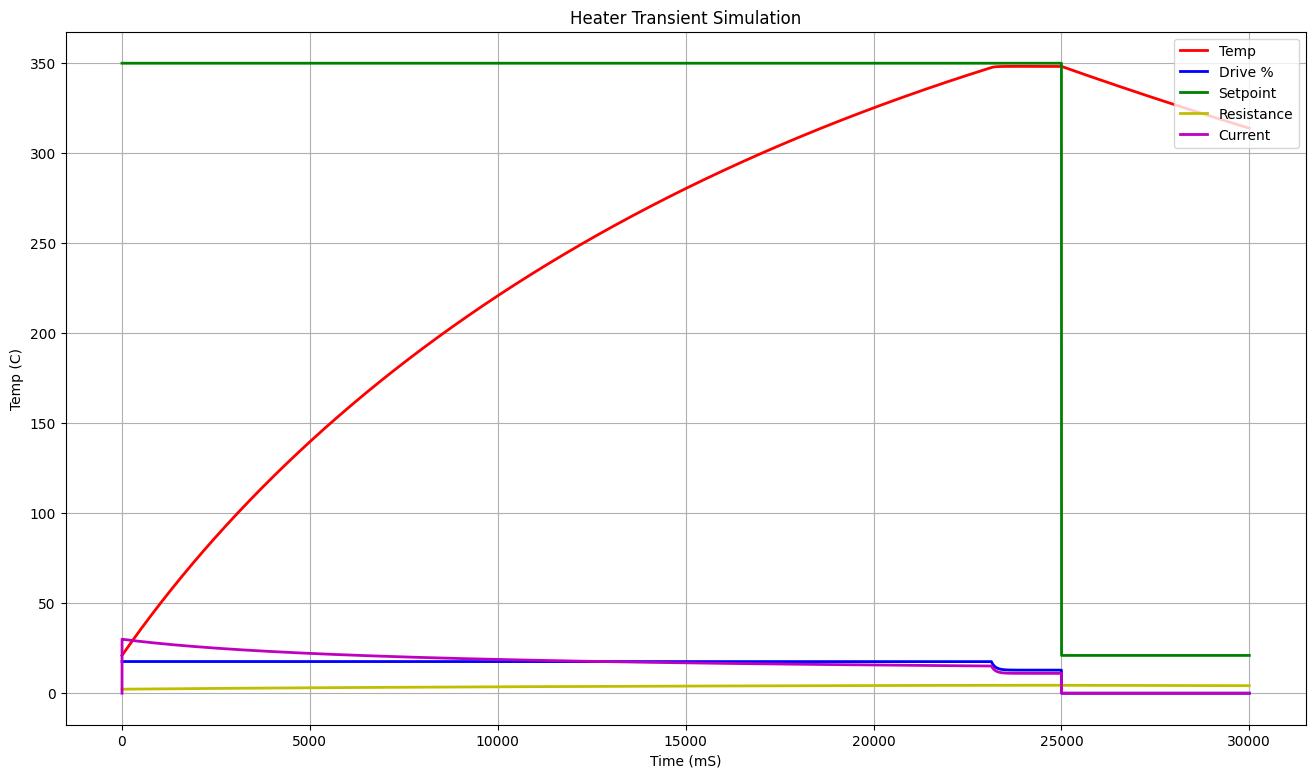

In [1]:
import time
import random
from pid import PID
import numpy as np
import matplotlib.pyplot as plt
import tabulate

# Constants
sigma = 5.67e-8  # Stefan-Boltzmann constant [W/m^2*K^4]
emissivity_h = 0.85 #emisivity of the Aluminum nitride heater
emissivity_s = 0.5 #emisivity of the surroundings
emissivity = 1 / ((1 / emissivity_h) + (1 / emissivity_s) - 1) #emisivity of the system
R_heater_0 = 2.23  # resistance of the heater [Ohm] at T_amb
V = 380.0  # heater voltage [V]
I_limit = 30  # current limit [A]
pwm_max_percent = min(1, I_limit /(V / R_heater_0)) #calculate the maximum drive fraction for the heater based on the ratio of the V/R_heater_0 to the current limit but contrin it to 1
h_n = 20  # natural convection heat transfer coefficient [W/m^2*K]
h_f = 3000  # forced cooling convection heat transfer coefficient [W/m^2*K]
h = h_f
A = .0258 * 2  # surface area for convection heat transfer [m^2] (per heater zone)
Cp = 740.0  # heater material heat capacity [J/kg*K]
Cp_b = 735.79  # block material heat capacity at 0C (linear fit from 20-400C)
Cp_m = 0.2105  # block material heat capacity  at 0C (linear fit from 20-400C)
mass = 0.090  # mass of the heater and coupled mass [kg](per heater zone)
T_amb = 21.0  # ambient temperature for convection [C]
alpha = 0.003  # temperature coefficient of resistance [1/C]

#Define a list of tuples containing the the constants defined above
constants = [
    ['Constants',           'Value',                            'Description'],
    ['sigma',               f'{sigma}',                         'Stefan-Boltzmann constant [W/m^2*K^4]'],
    ['emissivity_h',        f'{emissivity_h}',                  'emisivity of the Aluminum nitride heater'],
    ['emissivity_s',        f'{emissivity_s}',                  'emisivity of the surroundings'],
    ['emissivity',          f'{emissivity:.6f}',                'emisivity of the system'],
    ['R_heater_0',          f'{R_heater_0}',                    'resistance of the heater [Ohm] at T_amb'],
    ['V',                   f'{V}',                             'heater voltage [V]'],
    ['I_limit',             f'{I_limit}',                       'current limit [A]'],
    ['pwm_max_percent',     f'{pwm_max_percent * 100:.2f}',     'maximum drive fraction for the heater as a percentage'],
    ['h_n',                 f'{h_n}',                           'natural convection heat transfer coefficient [W/m^2*K]'],
    ['h_f',                 f'{h_f}',                           'forced cooling convection heat transfer coefficient [W/m^2*K]'],
    ['h',                   f'{h}',                             'heat transfer coefficient [W/m^2*K]'],
    ['A',                   f'{A}',                             'surface area for convection heat transfer [m^2] (per heater zone)'],
    ['Cp',                  f'{Cp}',                            'heater material heat capacity [J/kg*K]'],
    ['Cp_b',                f'{Cp_b}',                          'block material heat capacity at 0C (linear fit from 20-400C)'],
    ['Cp_m',                f'{Cp_m}',                          'block material heat capacity  at 0C (linear fit from 20-400C)'],
    ['mass',                f'{mass}',                          'mass of the heater and coupled mass [kg](per heater zone)'],
    ['T_amb',               f'{T_amb}',                         'ambient temperature for convection [C]'],
    ['alpha',               f'{alpha}',                         'temperature coefficient of resistance [1/C]']
]
# make a table and display
constants_table  = tabulate.tabulate(constants, tablefmt='html')
display(constants_table)

# Control Variables
Input = 21.0 # Initial temperature of the heater [°C]
Output = 0.0 # Initial output of the heater [0-100%]
Setpoint = 350.0 # Desired temperature of the heater [°C]

Kp = 300.0 # Proportional gain 
Ki = 0.0 # Integral gain
Kd = 0.0 # Derivative gain

emulation_dt_ms = 1  # Emulation time step [ms]
total_sim_time = 30000  # Total simulation time [ms]
Power_off_time = 25000 # Time to turn off the heater [ms] (increase to look at the cooling rate)

# Define a list of tuples containing the constant name, value, and comment
control_variables = [
    ['Control Variables',   'Value',                'Description'],
    ['Input',               f'{Input}',             'Initial temperature of the heater [°C]'],
    ['Output',              f'{Output}',            'Initial output of the heater [0-100%]'],
    ['Setpoint',            f'{Setpoint}',          'Desired temperature of the heater [°C]'],
    ['Kp',                  f'{Kp}',                'Proportional gain'],
    ['Ki',                  f'{Ki}',                'Integral gain'],
    ['Kd',                  f'{Kd}',                'Derivative gain'],
    ['emulation_dt_ms',     f'{emulation_dt_ms}',   'Emulation time step [ms]'],
    ['total_sim_time',      f'{total_sim_time}',    'Total simulation time [ms]'],
    ['Power_off_time',      f'{Power_off_time}',    'Time to turn off the heater [ms] (increase to look at the cooling rate)']
]
# make a table and display
control_table = tabulate.tabulate(control_variables, tablefmt='html')
display(control_table)

# PID controller
pid = PID(Input, Output, Setpoint, Kp, Ki, Kd, PID.DIRECT)

# Main function
def main():
    global emulation_dt_ms, R_heater

    pid.SetMode(PID.AUTOMATIC) # Set PID to automatic mode\
    pid.SetSampleTime(1)  # Sample time in seconds
    pid.SetOutputLimits(0, pwm_max_percent*4095)
    h = h_n # Start with natural convection
    Input_Data = np.array([])
    Output_Data = np.array([])
    Setpoint_Data = np.array([])
    Time_Data = np.array([])
    Resistance_Data = np.array([])
    Current_Data = np.array([])

    while pid.time_counter_ms < total_sim_time:  # Run for 5000 milliseconds (5 seconds)
        if pid.time_counter_ms > Power_off_time:
            pid.Setpoint = T_amb
        P_loss_c = h * A * (pid.Input - T_amb)  # Convection loss here only
        P_loss_r = sigma * A * emissivity * (pid.Input + 273.15) ** 4 # Radiation loss here only
        R_heater = R_heater_0 * (1 + alpha * (pid.Input - T_amb))  # Resistance of the heater
        P_heater = V * V / R_heater * pid.Output / 4095  # Power to the heater
        mCP = mass * (Cp_b + ( Cp_m * pid.Input))  # heat capacity C [J/K], save some computation time
        I_heater = V / R_heater * pid.Output / 4095
        random_noise = 0 # (random.uniform(-2.5, 2.5) / 10) # set to 0 to fall out of a coconut tree

        pid.Input = pid.Input + (((pid.Output / 4095 * P_heater) - P_loss_c - P_loss_r) / mCP * emulation_dt_ms / 1000) + random_noise

        pid.SetSampleTime(emulation_dt_ms)
        pid.Compute() # compute output and increment time counter by emulation_dt_ms

        current_time_ms = pid.time_counter_ms

        Input_Data = np.append(Input_Data, pid.Input)
        Output_Data = np.append(Output_Data, (pid.Output / 4095) * 100)
        Setpoint_Data = np.append(Setpoint_Data, pid.Setpoint)
        Time_Data = np.append(Time_Data, current_time_ms)
        Resistance_Data = np.append(Resistance_Data, R_heater)
        Current_Data = np.append(Current_Data, I_heater)
        #print(f'{current_time_ms/total_sim_time*100:.2f}% complete')
    # create a matplotlib line plot with input, output and setpoint over time
    plt.xlabel('Time (mS)')
    plt.ylabel('Temp (C)')
    plt.title('Heater Transient Simulation')
    plt.grid(True)
    plt.plot(Time_Data, Input_Data, 'r-', label='Temp', lw=2)
    plt.plot(Time_Data, Output_Data, 'b-', label='Drive %', lw=2)
    plt.plot(Time_Data, Setpoint_Data, 'g-', label='Setpoint', lw=2)
    plt.plot(Time_Data, Resistance_Data, 'y-', label='Resistance', lw=2)
    plt.plot(Time_Data, Current_Data, 'm-', label='Current', lw=2)
    # add a legend with legend entries
    plt.legend(loc='upper right')
    #set the plot size in pixels to 16x9 ratio with a width of 1600 pixels
    plt.gcf().set_size_inches(16, 9)

    plt.show()

if __name__ == "__main__":
    main()